# Individual Models

## Basic model pipeline
The basic procedure for all ITC experiments is:

1. Define a model.
2. Guess model parameters (which will always include at least one binding constant and reaction enthalpy).  
3. Use the guessed binding constant(s) to calculate the concentrations of all molecular species over the course of the experiment.
4. Combine the estimated species concentrations with the guessed enthalpy(s) to calculate the heat change for each shot. 
5. Compare the calculated and measured heat changes at each shot.  
6. Iterate through steps 2-5 using nonlinear regression to find maximum likelihood parameter estimates. 


## Differences from other modeling approaches

The models used py `pytc` differ from models in packages like Origin in several ways:
1. The dilution correction is a fittable parameter within each model, treated as a linear function of titrant concentration.  To incorporate a blank titration, you globally fit the dilution for the blank and production experiments as a single pair of parameters (slope and intercept).  
2. The stoichiometry of each model is fixed (rather than fittable). Instead, there is a `fx_competent` parameter that floats to account for inaccurate measurements of the concentrations of either the titrant or stationary phase.

## Blank

### [```indiv_models.Blank```](https://github.com/harmslab/pytc/blob/master/pytc/indiv_models/blank.py)

Titration of titrant into a cell without a stationary component.  

### Model parameters:

|parameter            | variable         | parameter name | class         |
|---------------------|------------------|----------------|---------------|
|slope of heat of dilution  | ---        | `dilution_heat`| nuisance      |
|interecept of heat of dilution   | ---  | `dilution_intercept`| nuisance |


### Calculate heat changes

The change in heat for each shot $i$ ($\Delta Q_{i}$) is:

$$q_{dilution,i} = [T]_{i} \times q_{slope} + q_{intercept}$$,
$$\Delta Q_{i} = q_{dilution,i},$$

where $[T]_{i}$ is the concentration of titrant at shot $i$, $q_{slope}$ is the slope of the heat of dilutionn (`dilution_heat`) and $q_{interecept}$ is the intercept of the heat of dilution (`dilution_intercept`).  

## Single-Site Binding

### [```indiv_models.SingleSite```](https://github.com/harmslab/pytc/blob/master/pytc/indiv_models/single_site.py)

This is a basic, single-site binding model.

### Model parameters:

|parameter            | variable         | parameter name | class         |
|---------------------|------------------|----------------|---------------|
|association constant | $K$              | `K`            | thermodynamic |
|binding enthalpy     | $\Delta H$       | `dH`           | thermodynamic |
|fraction competent   | ---              | `fx_competent` | nuisance      |
|slope of heat of dilution  | ---        | `dilution_heat`| nuisance      |
|interecept of heat of dilution   | ---  | `dilution_intercept`| nuisance |

### Model Scheme

Scheme is for binding of titrant $T$ to a stationary species $S$:

$$S + T \rightleftharpoons TS$$

To describe this, we use the following equilibrium constant:

$$K = \frac{[ST]}{[S]_{free}[T]_{free}}$$


### Determine the relative populations of species in solution

We can only manipulate $[T]_{total}$ and $[S]_{total}$ experimentally, so our first goal is to determine the concentration of $[ST]$ which we cannot manipulate or directly observe.  

$$K = \frac{[ST]}{([S]_{total} - [ST])([T]_{total}-[ST])}$$

$$K \Big ( [S]_{total}[T]_{total} - [ST]([S]_{total} + [T]_{total}) + [ST]^2 \Big ) = [ST]$$

$$[S]_{total}[T]_{total} - [ST]([S]_{total} + [T]_{total}) + [ST]^2 - [ST]/K = 0$$

$$[S]_{total}[T]_{total} - [ST]([S]_{total} + [T]_{total} + 1/K) + [ST]^2 = 0$$


The real root of this equation describes $[ST]$ in terms of $K$ and the total concentrations of $[S]$ and $[T]$:

$$[ST] = \frac{[S]_{total}  + [T]_{total} + 1/K - \sqrt{([S]_{total} + [T]_{total} + 1/K)^2 -4[S]_{total}[T]_{total}}}{2}$$

The mole fraction $ST$ is:

$$x_{ST} = \frac{[ST]}{[S]_{total}}$$

### Calculate heat changes

The change in heat for each shot $i$ ($\Delta Q_{i}$) is:

$$\Delta Q_{i} = V_{0}[S]_{total,i}(\Delta H(x_{ST,i} - x_{ST,i-1})) + q_{dilution,i},$$

where $V_{0}$ is the volume of the cell (fixed) and $\Delta H$ is the enthalpy of binding. Note that we do not deal with dilution here, as `pytc` calculates $x_{ST,i}$ for the entire titration, accouting for dilution at each step.  $V_{0}$ is held constant as the total cell volume (not the volume of solution including the neck) as only the cell, not the neck, is detected in the signal.  

## Competitive ligand binding

### [```indiv_models.SingleSiteCompetitor```](https://github.com/harmslab/pytc/blob/master/pytc/indiv_models/single_site_competitor.py)

This model was described by Sigurskjold BW (2000) *Analytical Biochemistry* 277(2):260-266 [link](http://dx.doi.org/10.1006/abio.1999.4402)

### Model parameters:

|parameter            | variable                  | parameter name | class         |
|---------------------|---------------------------|----------------|---------------|
|association constant | $K_{A}$                   | `K`            | thermodynamic |
|association constant | $K_{B}$                   | `Kcompetitor`  | thermodynamic |
|binding enthalpy for titrant    | $\Delta H_{A}$ | `dH`           | thermodynamic |
|binding enthalpy for competitor | $\Delta H_{B}$ | `dHcompetitor` | thermodynamic |
|fraction competent              | ---            | `fx_competent` | nuisance      |
|slope of heat of dilution       | ---            | `dilution_heat`| nuisance      |
|interecept of heat of dilution  | ---            | `dilution_intercept`| nuisance |

### Model Scheme

Scheme is for competitive binding of $A$ and $B$ to protein $P$:

$$A + P \rightleftharpoons PA$$
$$B + P \rightleftharpoons PB$$

To describe this, we use the following equilibrium constants:

$$K_{A} = \frac{[PA]}{[P]_{free}[A]_{free}}$$

$$K_{B} = \frac{[PB]}{[P]_{free}[B]_{free}}$$


### Determine the relative populations of species in solution

We can only manipulate $[P]_{total}$, $[A]_{total}$ and $[B]_{total}$ experimentally, so our first goal is to determine the concentrations of species such as $[PA]$ which we cannot manipulate or directly observe.  Start by writing concentrations as mole fractions:

$$x_{P} = \frac{[P]_{free}}{[P]_{total}}$$

$$x_{PA} = \frac{[PA]}{[P]_{total}}$$

$$x_{PB} = \frac{[PB]}{[P]_{total}}$$

$$x_{P} + x_{PA} + x_{PB} = 1$$

A root of the binding polynomial has been found that describes $x_{P}$ only in terms of $K_{A}$, $K_{B}$, $[A]_{total}$, $[B]_{total}$ and $[P]_{total}$.  Start with some convenient definitions:

$$c_{A} = K_{A}[P]_{total}$$

$$c_{B} = K_{B}[P]_{total}$$

$$r_{A} = \frac{[A]_{total}}{P_{total}}$$

$$r_{B} = \frac{[B]_{total}}{P_{total}}$$

The value of $x_{P}$ is given by:

$$\alpha = \frac{1}{c_{A}} + \frac{1}{c_{B}} + r_{A} + r_{B} - 1$$

$$\beta = \frac{r_{A}-1}{c_{B}} + \frac{r_{B} - 1}{c_{A}} + \frac{1}{c_{A}c_{B}}$$

$$\gamma = -\frac{1}{c_{A}c_{B}}$$

$$\theta = arccos \Big ( \frac{-2\alpha^{3} + 9\alpha \beta -27\gamma}{2\sqrt{(\alpha^2 - 3 \beta)^3}} \Big) $$

$$x_{P} = \frac{2\sqrt{\alpha^2 - 3 \beta}\ cos(\theta/3) - \alpha}{3}$$

Once this is known $x_{PA}$ and $x_{PB}$ are uniquely determined by:

$$x_{PA} = \frac{r_{A} x_{P}}{1/C_{A} + x_{P}}$$

$$x_{PB} = \frac{r_{B} x_{P}}{1/C_{B} + x_{P}}$$

### Calculate heat changes

The change in heat for each shot $i$ ($\Delta Q_{i}$) is:

$$\Delta Q_{i} = V_{0}P_{total}(\Delta H_{A}(x_{PA,i} - f_{i}x_{PA,i-1}) + \Delta H_{B}(x_{PB,i} - f_{i}x_{PB,i-1})) + q_{dilution},$$

where $V_{0}$ is the volume of the cell, $\Delta H_{A}$ is the enthalpy for binding ligand $A$, $\Delta H_{B}$ is the enthalpy for binding ligand $B$. $f_{i}$ is the dilution factor for each injection: 

$$f_{i} = exp(-V_{i}/V_{0}),$$

where $V_{0}$ is the volume of the cell and $V_{i}$ is the volume of the $i$-th injection.

`pytc` calculates $x_{PA,i}$ and friends for the entire titration, correcting for dilution.  This means the $f_{i}$ term is superfluous.  Thus, heats are related by:

$$\Delta Q_{i} = V_{0}P_{total,i}(\Delta H_{A}(x_{PA,i} - x_{PA,i-1}) + \Delta H_{B}(x_{PB,i} - x_{PB,i-1})) + q_{dilution}.$$

Note that $V_{0}$ is held constant (it is the cell volume) as only that volume is detected, not the neck of the cell.




## Binding Polynomial

### [```indiv_models.BindingPolynomial```](https://github.com/harmslab/pytc/blob/master/pytc/indiv_models/binding_polynomial.py)

This model was described by Freire et al. (2009). *Methods in Enzymology* 455:127-155 [link](http://www.sciencedirect.com/science/article/pii/S0076687908042055)

### Model parameters:

|parameter            | variable                  | parameter name | class         |
|---------------------|---------------------------|----------------|---------------|
|adair constant | $\beta_{i}$               | `beta1`        | thermodynamic |
|adair constant | $\beta_{i+1}$             | `beta2`        | thermodynamic |
|binding enthalpy for titrant    | $\Delta H_{i}$ | `dH1`          | thermodynamic |
|binding enthalpy for competitor | $\Delta H_{i+1}$ | `dH2`        | thermodynamic |
|fraction competent              | ---            | `fx_competent` | nuisance      |
|slope of heat of dilution       | ---            | `dilution_heat`| nuisance      |
|interecept of heat of dilution  | ---            | `dilution_intercept`| nuisance |

Will have as many $\beta$ and $\Delta H$ terms as sites defined in the model.


### Model Scheme

The scheme is:

$$S + iT \rightleftharpoons ST_{i}$$

where $S$ is the stationary species and $T$ is the titrant.  This is an overall binding polynomial, meaning that we account for the total loading of $i$ molecules of $T$ onto $S$. The equilibrium constants (Adair constants) are:

$$\beta_{i} = \frac{[ST_{i}]}{[S][T]^{i}}$$

This model is entirely general (and therefore phenomenological), but is an appropriate starting point for analyzing a complex binding reaction.  The Adair constants can be related to a sequential binding model by:

$$S + T \rightleftharpoons ST$$
$$ST + T \rightleftharpoons ST_{2}$$
$$...$$
$$ST_{i-1} + T \rightleftharpoons ST_{i}$$

$$K_{i} = \frac{[ML_{i}]}{[ML_{i-1}][L]} = \frac{\beta_{i}}{\beta_{i-1}}$$

### Determine the relative populations of species in solution

The first thing to note is that the binding polynomial $P$ is a partition function:

$$P = \sum_{i=0}^{n}\frac{[ST_{i}]}{[S]} = \sum_{i=0}^{n} \beta_{i}[T]^{i}$$

This allows us to write equations for the average enthalphy and number of ligand molecules bound:

$$\langle \Delta H \rangle = \frac{\sum_{i=0}^{n} \Delta H_{i} \beta_{i}[T]^{i}} {\sum_{i=0}^{n} \beta_{i}[T]^{i}}$$

and 

$$\langle n \rangle = \frac{\sum_{i=0}^{n} i \beta_{i}[T]^{i}} {\sum_{i=0}^{n} \beta_{i}[T]^{i}}$$

This means that obtaining the relative populations of species in solution is (relatively) simple:

$$[T]_{total} = [T]_{bound} + [T]_{free}$$

$$[T]_{total} = \langle n \rangle[S]_{total} + [T]_{free}$$

$$0 = \langle n \rangle[S]_{total} + [T]_{free} - [T]_{total}$$


$$0 = \frac{\sum_{i=0}^{n} i \beta_{i}[T]_{free}^{i}} {\sum_{i=0}^{n} \beta_{i}[T]_{free}^{i}}[S]_{total} + [T]_{free} - [T]_{total}$$

This can then be solved numerically for a value of $[T]_{free}$.  

### Calculate heat changes

We can relate the heat at shot to the average enthalpies calculated using the value of $T_{free}$ over the titration.  Recalling:

$$\langle \Delta H \rangle = \frac{\sum_{i=0}^{n} \Delta H_{i} \beta_{i}[T]_{free}^{i}} {\sum_{i=0}^{n} \beta_{i}[T]_{free}^{i}}$$

we can calculate the change in heat for shot $j$ as:

$$\Delta Q_{j} = V_{0} S_{total,j} (\langle \Delta H \rangle_{j} - \langle \Delta H \rangle_{j-1}) + q_{dilution,i}.$$




# Global Models

## Generic Global Model

### [```global_models.GlobalFit```](https://github.com/harmslab/pytc/blob/master/pytc/global_models/base.py)

Fits a collection of ITC experiments to individual models.  The parameters of these models can be arbitrarily linked to one another.  For example, for three replicate measurement, $K$ and $\Delta H$ could be shared across expeirments, while the fraction competent and the baselines were allowed to float for each one.

# Fit successful? True
# Fit sum of square residuals: 1.9889796147455734
# Fit num param: 11
# Fit num observations: 162
# Fit num degrees freedom: 151
type,name,dh_file,value,uncertainty,fixed,guess,lower_bound,upper_bound
global,global_K,NA,3.93195e+07,3.37658e-06,float,1.00000e+06,-inf,inf
global,global_dH,NA,-1.16696e+04,1.14751e-02,float,-4.00000e+03,-inf,inf
local,dilution_intercept,demos/ca-edta/tris-01.DH,4.14047e-02,0.00000e+00,float,0.00000e+00,-inf,inf
local,fx_competent,demos/ca-edta/tris-01.DH,9.73974e-01,0.00000e+00,float,1.00000e+00,-inf,inf
local,dilution_heat,demos/ca-edta/tris-01.DH,-3.20328e+03,0.00000e+00,float,0.00000e+00,-inf,inf
local,dilution_intercept,demos/ca-edta/tris-02.DH,-7.89145e-01,1.62309e-01,float,0.00000e+00,-inf,inf
local,fx_competent,demos/ca-edta/tris-02.DH,9.99232e-01,3.11366e-02,float,1.00000e+00,-inf,inf
local,dilution_heat,demos/ca-edta/tris-02.DH,3.84439e+03,6.24525e-04,float,0.00000e+00,-inf,inf
local,dilution_intercept,demos/ca-edta/tris-03.

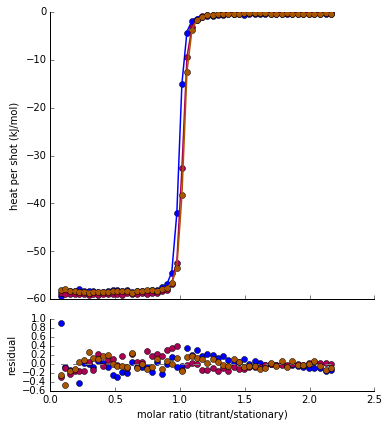

In [6]:
import pytc
%matplotlib inline

# --------------------------------------------------------------------
# Create a global fitting instance
g = pytc.global_models.GlobalFit()

# --------------------------------------------------------------------
# Load in an experimental data set with a single-site binding model
a = pytc.ITCExperiment("demos/ca-edta/tris-01.DH",pytc.indiv_models.SingleSite,shot_start=2)

# Add the experiment to the fitter.  Then link the dilution heat and
# intercept to global parameters
g.add_experiment(a)
g.link_to_global(a,"K","global_K")
g.link_to_global(a,"dH","global_dH")

# --------------------------------------------------------------------
# Load in a second experimental data set with a single-site binding model
b = pytc.ITCExperiment("demos/ca-edta/tris-02.DH",pytc.indiv_models.SingleSite,shot_start=2)

# Add a blank titration to the fitter. Then link the dilution heat and
# intercept to global parameters
g.add_experiment(b)
g.link_to_global(b,"K","global_K")
g.link_to_global(b,"dH","global_dH")


# --------------------------------------------------------------------
# Load in a third experimental data set with a single-site binding model
c = pytc.ITCExperiment("demos/ca-edta/tris-03.DH",pytc.indiv_models.SingleSite,shot_start=2)

# Add a blank titration to the fitter. Then link the dilution heat and
# intercept to global parameters
g.add_experiment(c)
g.link_to_global(c,"K","global_K")
g.link_to_global(c,"dH","global_dH")

# --------------------------------------------------------------------
# Do a global fit to the single-site and blank titrations
g.fit()

# --------------------------------------------------------------------
# Show the results
fig, ax = g.plot()
print(g.fit_as_csv)


## Proton Linked

### [```global_models.ProtonLinked```](https://github.com/harmslab/pytc/blob/master/pytc/global_models/proton_linked.py)

Fits a collection of ITC experiments collected in buffers of the same pH, but different ionization enthalpy. The `.add_experiment` method is subclassed to require an `ionization_enthalpy` for each experiment.  The model also adds the new global parameter `n_protons` (the number of protons released or taken up during binding).  For experiment $x$, the enthalpy is given by: 

$$\Delta H_{x} = \Delta H_{bind} + \Delta H_{ionization,x} \times n_{proton}$$

By performing experiments in at least two buffers with different ionization enthalpy, one can extract the buffer-independent $\Delta H_{bind}$ and the number of protons taken up or released.

# Fit successful? True
# Fit sum of square residuals: 1.6065490880410385
# Fit num param: 9
# Fit num observations: 108
# Fit num degrees freedom: 99
type,name,dh_file,value,uncertainty,fixed,guess,lower_bound,upper_bound
global,global_K,NA,4.41940e+07,3.09724e-06,float,1.00000e+06,-inf,inf
global,num_protons,NA,-9.39633e-01,1.19194e+00,float,0.00000e+00,-inf,inf
global,dH_global,NA,-8.67688e+02,1.27368e-02,float,-4.00000e+03,-inf,inf
local,dilution_intercept,demos/ca-edta/imid-01.DH,1.73664e-01,1.80154e-01,float,0.00000e+00,-inf,inf
local,fx_competent,demos/ca-edta/imid-01.DH,9.85084e-01,3.21248e-02,float,1.00000e+00,-inf,inf
local,dilution_heat,demos/ca-edta/imid-01.DH,-3.30234e+03,7.70631e-04,float,0.00000e+00,-inf,inf
local,dilution_intercept,demos/ca-edta/tris-01.DH,-8.77131e-01,0.00000e+00,float,0.00000e+00,-inf,inf
local,fx_competent,demos/ca-edta/tris-01.DH,9.73905e-01,0.00000e+00,float,1.00000e+00,-inf,inf
local,dilution_heat,demos/ca-edta/tris-01.DH,2.88110e+03,0.00000e+00,fl

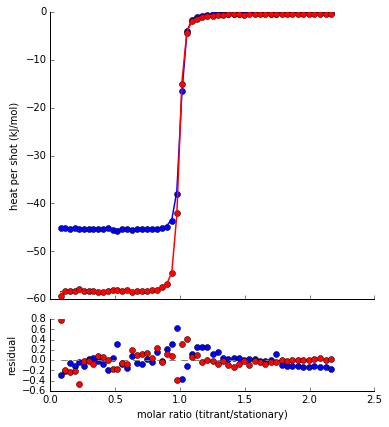

In [2]:
# --------------------------------------------------------------------
# define buffer ionization enthalpies.
# goldberg et al (2002) Journal of Physical and Chemical Reference Data 31 231,  doi: 10.1063/1.1416902
IMID_IONIZATION_DH = 36.64/4.184*1000
TRIS_IONIZATION_DH = 47.45/4.184*1000 

%matplotlib inline
import pytc

# --------------------------------------------------------------------
# Create a global fitting instance
g = pytc.global_models.ProtonLinked()

# ------------------------------------------------------------------------------------
# HEPES buffer experiment

hepes = pytc.ITCExperiment("demos/ca-edta/imid-01.DH",pytc.indiv_models.SingleSite,shot_start=2)

g.add_experiment(hepes,ionization_enthalpy=IMID_IONIZATION_DH)
g.link_to_global(hepes,"K","global_K")
g.link_to_global(hepes,"dH","dH_global")

# ------------------------------------------------------------------------------------
# Tris buffer experiment

tris = pytc.ITCExperiment("demos/ca-edta/tris-01.DH",pytc.indiv_models.SingleSite,shot_start=2)

g.add_experiment(tris,ionization_enthalpy=TRIS_IONIZATION_DH)
g.link_to_global(tris,"K","global_K")
g.link_to_global(tris,"dH","dH_global")

# Do a global fit
g.fit()

# Show the results
fig, ax = g.plot()
print(g.fit_as_csv)

## Temperature-Dependent

### [```global_models.TempDependence```](https://github.com/harmslab/pytc/blob/master/pytc/global_models/temp_dependence.py)

Fits a collection of ITC experiments collected in identical buffer conditions, but different temperatures.  The temperature of each experiment is taken from the heats file. The model adds the new global parameter `dCp` (the heat capacity change on binding). For experiment $x$, the enthalpy is given by: 

$$\Delta H_{x} = \Delta H_{bind} + \Delta C_{p} \times T_{x}$$

By performing experiments at a minimum of two temperatures, one can extract the enthalpy at $0 \ K$ and the $\Delta C_{p}$ for binding.